In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/전처리/법정동_일별_날씨_전력량.csv")
df.head()

,전체코드,시군구코드,시군구명,법정동코드,법정동명,날짜,파워,평균기온(°C),최저기온(°C),최고기온(°C),...,평균 20cm 지중온도(°C),평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm)
0,1111010100,11110,종로구,10100,청운동,2022-12-04,146294.6135,-3.5,-5.2,-0.2,...,3.5,5.2,7.5,12.1,15.6,18.4,18.7,1.2,1.7,0.0
1,1111010100,11110,종로구,10100,청운동,2022-12-05,175633.8270,-3.1,-7.0,1.9,...,2.8,4.6,7.0,11.7,15.3,18.4,18.7,1.5,2.1,0.1
2,1111010100,11110,종로구,10100,청운동,2022-12-06,156084.1910,0.9,-3.9,5.3,...,2.4,4.1,6.6,11.3,15.1,18.3,18.7,1.3,1.9,0.1
3,1111010100,11110,종로구,10100,청운동,2022-12-08,177018.8420,3.7,0.1,9.1,...,3.6,4.8,6.6,10.7,14.5,18.2,18.6,1.5,2.2,0.0
4,1111010100,11110,종로구,10100,청운동,2022-12-09,158467.1690,4.5,0.9,10.2,...,3.9,4.9,6.6,10.5,14.3,18.1,18.6,1.2,1.8,0.0


In [8]:
df["날짜"] = pd.to_datetime(df["날짜"])

In [9]:
df["year"] = df["날짜"].dt.year
df["month"] = df["날짜"].dt.month
df["day"] = df["날짜"].dt.day
df["weekday"] = df["날짜"].dt.weekday  # 월=0
df["is_weekend"] = (df["weekday"] >= 5).astype(int)

# 계절 주기 인식
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

In [10]:
# 온도 기반 파생 변수 (핵심)
df["일교차"] = df["최고기온(°C)"] - df["최저기온(°C)"]

df["냉방지수"] = np.maximum(0, df["평균기온(°C)"] - 24)
df["난방지수"] = np.maximum(0, 18 - df["평균기온(°C)"])

In [11]:
group_key = "법정동코드"

# 전력 Lag
df["파워_lag1"] = df.groupby(group_key)["파워"].shift(1)
df["파워_lag7"] = df.groupby(group_key)["파워"].shift(7)

# 기온 Lag / Rolling
df["평균기온_lag1"] = df.groupby(group_key)["평균기온(°C)"].shift(1)
df["평균기온_roll3"] = (
    df.groupby(group_key)["평균기온(°C)"]
      .shift(1)
      .rolling(3)
      .mean()
)

In [12]:
feature_cols = [
    # 식별
    "전체코드", "시군구코드", "법정동코드",

    # 기본 날씨
    "평균기온(°C)", "최저기온(°C)", "최고기온(°C)",
    "평균 상대습도(%)", "일강수량(mm)", "평균 풍속(m/s)",

    # 파생
    "일교차", "냉방지수", "난방지수",

    # 시간
    "weekday", "is_weekend", "month_sin", "month_cos",

    # Lag
    "파워_lag1", "파워_lag7",
    "평균기온_lag1", "평균기온_roll3",
]

target_col = "파워"

new_df = df[["날짜"] + feature_cols + [target_col]].dropna().reset_index(drop=True)

In [13]:
df = df.sort_values(["전체코드", "날짜"])  # 또는 법정동코드/전체코드 중 실제 키로

out = []
for code, g in df.groupby("전체코드"):
    g = g.set_index("날짜").asfreq("D")      # 빠진 날짜 생성
    g["전체코드"] = code
    out.append(g.reset_index())

df2 = pd.concat(out, ignore_index=True)

# 빠진 날짜의 파워 처리(선택)
# 1) 보간(부드럽게)
# df2["파워"] = df2.groupby("전체코드")["파워"].interpolate()

# 2) 전일값 유지(계단형)
# df2["파워"] = df2.groupby("전체코드")["파워"].ffill()

df2["파워_lag1"] = df2.groupby("전체코드")["파워"].shift(1)
df2["파워_lag7"] = df2.groupby("전체코드")["파워"].shift(7)

In [14]:
import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

target_col = "파워"

In [15]:
# =========================
# 1) 시간순 Train/Valid/Test 분할
# =========================
new_df = new_df.sort_values("날짜").reset_index(drop=True)

# 마지막 20%를 테스트, 그 앞 10%를 검증으로 쓰는 예시
n = len(new_df)
test_size = int(n * 0.20)
valid_size = int(n * 0.10)

train_end = n - (valid_size + test_size)
valid_end = n - test_size

train_df = new_df.iloc[:train_end]
valid_df = new_df.iloc[train_end:valid_end]
test_df  = new_df.iloc[valid_end:]


In [16]:
# =========================
# 2) X / y 분리
# =========================
drop_cols = [target_col, "날짜"]  # 날짜는 직접 입력 피처로 쓰지 않음(우린 파생변수로 이미 반영)
X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target_col]

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target_col]

In [22]:
cat_cols = ["전체코드", "시군구코드", "법정동코드"]

for c in cat_cols:
    X_train[c] = X_train[c].astype("int64")
    X_test[c]  = X_test[c].astype("int64")

In [23]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,

    max_depth=5,
    min_child_weight=5,

    subsample=0.8,
    colsample_bytree=0.8,

    gamma=0.1,              # 불필요한 분기 억제
    reg_alpha=0.0,
    reg_lambda=5.0,         # L2 강화 (중요)

    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"[XGB] RMSE: {rmse:,.2f}")
print(f"[XGB] R2  : {r2:.4f}")

[XGB] RMSE: 96,119.48
[XGB] R2  : 0.8210


In [19]:
import pandas as pd

imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=False)

imp.head(20)

,feature,importance
16,파워_lag1,0.407730
17,파워_lag7,0.093113
1,시군구코드,0.085330
0,전체코드,0.084967
14,month_sin,0.058693
11,난방지수,0.051856
15,month_cos,0.021895
13,is_weekend,0.019760
2,법정동코드,0.019711
18,평균기온_lag1,0.017882


C:\Users\Admin\AppData\Local\Temp\ipykernel_9448\1769443156.py:20: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_9448\1769443156.py:20: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_9448\1769443156.py:20: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_9448\1769443156.py:20: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_9448\1769443156.py:20: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_9448\1769443156.py:20: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  plt.tight_layout()
C

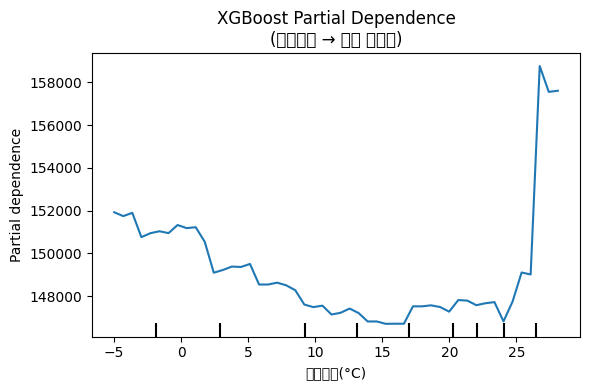

In [21]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

feature_name = "평균기온(°C)"  # 네 모델에 실제 들어간 컬럼명

fig, ax = plt.subplots(figsize=(6, 4))

PartialDependenceDisplay.from_estimator(
    xgb_model,
    X_train,
    features=[feature_name],
    grid_resolution=50,
    ax=ax
)

ax.set_title("XGBoost Partial Dependence\n(평균기온 → 전력 사용량)")
ax.set_ylabel("예측 전력 사용량")
ax.set_xlabel("평균기온 (°C)")

plt.tight_layout()
plt.show()